# Implementación del esquema de BOF-BoVW para el reconocimiento de escenas

## Análisis de datos exploratorio

In [1]:
!pwd

/home/mario/Documents/ScenesRecognition-AYUDAME/BoVW


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import scipy.cluster.vq as vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from joblib import dump, load
from BoVW import *

In [3]:
class_names = np.load("Datasets/data04/class_names_04.npy")
pcd_names = np.load("Datasets/data04/pcd_names_04.npy")
targets = np.load("Datasets/data04/targets_04.npy")
filehandler = open("Datasets/data04/bofs_04.bin", 'rb')
bofs = pickle.load(filehandler)
filehandler.close()

In [4]:
class_names

array(['chess', 'fire', 'heads', 'office', 'pumpkin', 'redkitchen',
       'stairs'], dtype='<U10')

In [5]:
print(pcd_names[:3])
print(pcd_names.shape)

['frame-000000' 'frame-000001' 'frame-000002']
(6500,)


In [6]:
print(targets[:3])
print(targets.shape)

[0 0 0]
(6500,)


In [7]:
print(len(bofs))
for bof in bofs[:3]:
    print(bof.shape)

6500
(1, 180)
(1, 180)
(1, 180)


In [8]:
bofs_np = np.vstack(bofs)
bofs_np.shape

(19244, 180)

In [9]:
classes,count_classes = np.unique(targets, return_counts=True)
class_dict = dict(zip(classes.astype('int'),count_classes))
print(class_dict)

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 500}


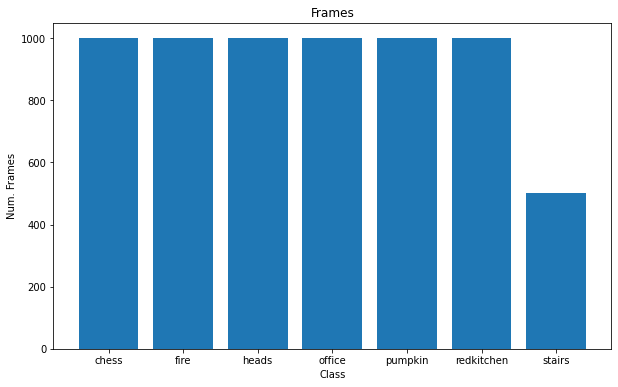

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(classes, count_classes,tick_label=class_names)
plt.title('Frames')
plt.ylabel('Num. Frames')
plt.xlabel('Class')
plt.show()

### División de datos

In [11]:
X_train, X_test, y_train, y_test = train_test_split(bofs, targets,
    shuffle = True, random_state = 8)

In [12]:
print(len(X_train))

4875


## BoVW

In [13]:
k = 256
codebook = getCodebook(X_train,k,None,13)

Computing kmeans on 14484 samples with 256 centroids
The codebook generation took 83.491086[s] CPU, 12.641538[s] real


In [14]:
%%time
bofs_quantized,bofs_q_dis = vq.vq(np.vstack(X_train),codebook)

CPU times: user 232 ms, sys: 237 ms, total: 469 ms
Wall time: 102 ms


In [15]:
np.mean(bofs_q_dis)

1.443699794542453

A continuación se revisa la distribución del vocabulario visual con respecto a las BOF, es decir,
por cada palabra en el vocabulario, cuantas BOF asignadas tiene.

In [16]:
code,count_code = np.unique(bofs_quantized, return_counts=True)
code_dic = dict(zip(code,count_code))
# print(code_dic)

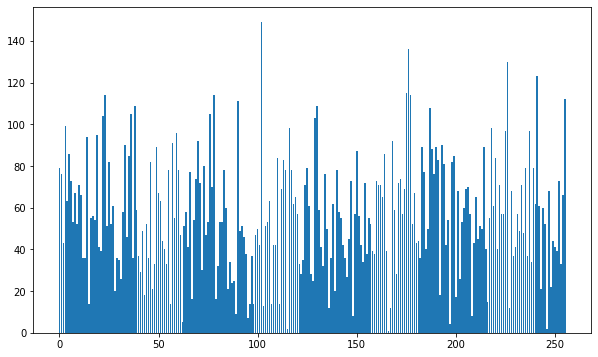

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(code, count_code)
plt.show()

Persistencia del codebook

In [37]:
np.save("codebook02",codebook)

### Obtención de la representación BoVW

In [18]:
vw_train = getBoVWRepresentation(X_train,codebook)
vw_train.shape

Processing histogram generation over 4875 samples
The histogram generation took 5.604211[s] CPU, 1.002298[s] real


(4875, 256)

In [19]:
vw_train[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [21]:
vw_test = getBoVWRepresentation(X_test,codebook)
vw_test.shape

Processing histogram generation over 1625 samples
The histogram generation took 1.685554[s] CPU, 0.361215[s] real


(1625, 256)

## Preprocesamiento de datos
### Estandarización de datos

In [22]:
stdSlr = StandardScaler()
train = vw_train
train = stdSlr.fit_transform(train)
train[0]

array([-0.12834352, -0.12584369, -0.09433455, -0.14397445,  8.73962   ,
       -0.12807976, -0.12329639, -0.10483935, -0.11804706, -0.10383482,
       -0.12157035, -0.11715061, -0.08625285, -0.08179621, -0.14021824,
       -0.05366625, -0.10682129, -0.1077992 , -0.10583476, -0.14097688,
       -0.09209554, -0.08980265, -0.14764269, -0.15474027, -0.1028209 ,
       -0.13079864, -0.10383482, -0.11256721, -0.06418305, -0.08625285,
       -0.08503766, -0.0732252 , -0.09977987, -0.1313274 , -0.09760012,
       -0.1332115 , -0.14836636, -0.08625285, -0.1512294 , -0.11068347,
       -0.08745163, -0.07735837, -0.09874859, -0.06087685, -0.10383482,
       -0.08625285, -0.12203164, -0.06577484, -0.08255523, -0.13636681,
       -0.11804706, -0.11442145, -0.09543503, -0.09095608, -0.08255523,
       -0.12431704, -0.05366625, -0.13212794, -0.10682129, -0.14173174,
       -0.12751535, -0.09866549, -0.03204206, -0.09897335, -0.10973008,
       -0.09209554, -0.11511195, -0.05738344, -0.10583476, -0.12

In [23]:
print(f"mean = {np.mean(stdSlr.mean_)}")
print(f"var = {np.mean(stdSlr.var_)}")

mean = 0.01160576923076923
var = 0.011663043063773743


In [24]:
test = vw_test
test = stdSlr.transform(test)

### Análisis de componentes principales

In [42]:
pca = PCA()
pca.fit(train)
pca.explained_variance_ratio_

array([0.01595764, 0.01271896, 0.01231668, 0.01208354, 0.01119396,
       0.01073583, 0.01031986, 0.01022761, 0.01012168, 0.00969572,
       0.00954958, 0.00921163, 0.00898627, 0.00885287, 0.00872653,
       0.00853367, 0.00824769, 0.00802489, 0.00790226, 0.00781044,
       0.00762845, 0.00755407, 0.00749582, 0.00743713, 0.00732017,
       0.00726952, 0.00719905, 0.00715686, 0.00708885, 0.00704312,
       0.00698117, 0.00689769, 0.00683015, 0.00681463, 0.00665566,
       0.00660332, 0.00651685, 0.00645714, 0.00638369, 0.0063318 ,
       0.00629803, 0.00626778, 0.00622336, 0.00618919, 0.00615086,
       0.0061149 , 0.00603805, 0.00602054, 0.00595657, 0.00589405,
       0.00584516, 0.00579931, 0.00579131, 0.00573451, 0.00570978,
       0.00566268, 0.00560241, 0.00556357, 0.00553517, 0.00547057,
       0.0054405 , 0.00541411, 0.00538286, 0.00531439, 0.00527839,
       0.00522586, 0.00517931, 0.00515571, 0.00512678, 0.00508629,
       0.0050748 , 0.00503695, 0.00502622, 0.00500315, 0.00494

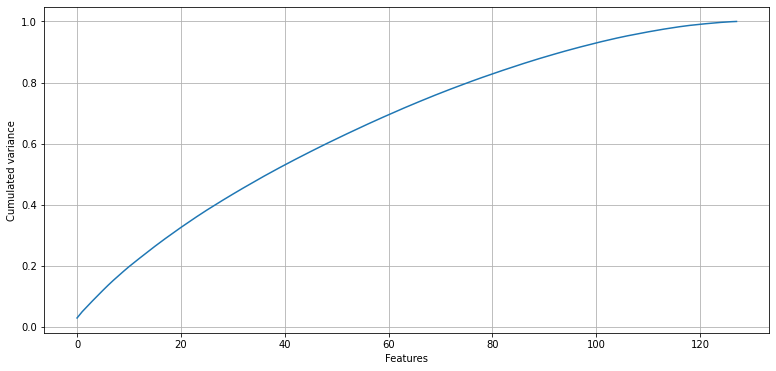

In [24]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(13,6))
plt.plot(cum_var)
plt.xlabel('Features')
plt.ylabel('Cumulated variance')
plt.grid()
plt.show()

In [25]:
cum_var[89]

0.8783105

In [26]:
train_red = pca.transform(train)
train_red = train_red[:,:90]
train_red.shape

(1146, 90)

In [27]:
test_red = pca.transform(test)
test_red = test_red[:,:90]
test_red.shape

(382, 90)

## Clasificación

In [26]:
%%time
folds=5
start=0.01
end=10
numparams=15

tuned_parameters = [{'kernel': ['rbf'], 'C':np.linspace(start,end,num=numparams)}]
# tuned_parameters = [{'kernel': ["linear", "poly", "rbf", "sigmoid"], 'C':[1]}]
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=folds,scoring='accuracy')
clf.fit(train, y_train)
print(clf.best_params_)

{'C': 3.577857142857143, 'kernel': 'rbf'}
CPU times: user 3min 4s, sys: 146 ms, total: 3min 4s
Wall time: 3min 6s


In [32]:
%%time
classifier = svm.SVC(C=3.58,kernel='rbf').fit(train,y_train)

CPU times: user 4.07 s, sys: 11.5 ms, total: 4.08 s
Wall time: 4.17 s


In [27]:
%%time
100*classifier.score(train, y_train)
# 100*clf.score(train, y_train) # 91.62303665 with pca, 90 features

CPU times: user 4.53 s, sys: 4.02 ms, total: 4.53 s
Wall time: 4.58 s


99.67179487179487

In [33]:
%%time
100*classifier.score(test, y_test)
# 100*clf.score(test, y_test)
# 77.48691099 with pca, 90 features, 128 words
# 79.3193 with 512 words, C=2.0768

CPU times: user 1.62 s, sys: 5.81 ms, total: 1.62 s
Wall time: 1.64 s


92.80000000000001

## Evaluación de resultados

In [34]:
test_pred = classifier.predict(test)

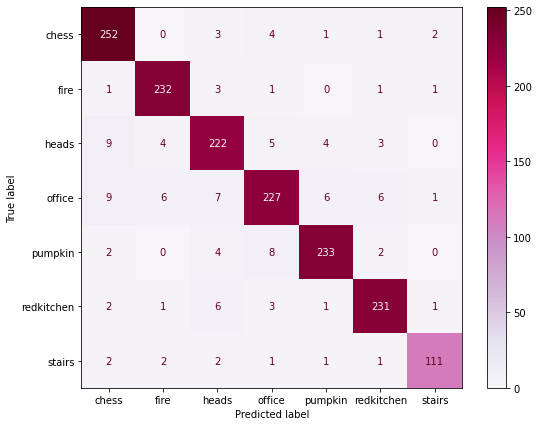

In [35]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=test_pred,
                                              ax=ax,cmap='PuRd',display_labels=class_names)
plt.show()

In [36]:
print(classification_report(y_true=y_test,y_pred=test_pred,target_names=class_names))

              precision    recall  f1-score   support

       chess       0.91      0.96      0.93       263
        fire       0.95      0.97      0.96       239
       heads       0.90      0.90      0.90       247
      office       0.91      0.87      0.89       262
     pumpkin       0.95      0.94      0.94       249
  redkitchen       0.94      0.94      0.94       245
      stairs       0.96      0.93      0.94       120

    accuracy                           0.93      1625
   macro avg       0.93      0.93      0.93      1625
weighted avg       0.93      0.93      0.93      1625



## Persistencia del modelo
Para la persistencia del modelo se utiliza `joblib`, que es una implemenatción más eficiente de pickle.

Se utiliza `dump` para almacenar el modelo.

In [37]:
dump(classifier, "model02.joblib")

['model02.joblib']

De igual forma se almacena el estandarizador

In [38]:
dump(stdSlr,"standard_scaler02.joblib")

['standard_scaler02.joblib']

Se utiliza `load` para leerlo.

In [39]:
clf = load('model02.joblib')

In [40]:
clf.get_params()

{'C': 3.58,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}